# Simulation of request sent to Node Balancer

We have a constant stream of requests coming, with the caveat that each request completion time can vary by quite a lot.

Let's visualize how different load balancer strategies can impact the overall load of the system. Specifically, we will analyze three balancing strategies:
- Classic Round Robin
- Hash-based -> AKA, at random
- Least Loaded

## Utils

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import hashlib
import math
import time
import uuid
from collections import deque
from dataclasses import dataclass
import polars as pl
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

### Consumer

In [11]:
@dataclass
class Request:
    request_id: str
    time_to_fulfill: int


class Consumer:
    def __init__(self, node_id: int):
        self.node_id = node_id
        self.request_queue: deque = deque()
        self._current_request: Request | None = None

    @property
    def time_to_fulfill_all_requests(self) -> int:
        time_to_fulfill = 0
        if self._current_request is not None:
            time_to_fulfill += self._current_request.time_to_fulfill
        for request in self.request_queue:
            time_to_fulfill += request.time_to_fulfill
        return time_to_fulfill

    def assign_request(self, request: Request):
        self.request_queue.append(request)

    def consume(self):
        if self._current_request is None and len(self.request_queue) > 0:
            self._current_request = self.request_queue.popleft()

        if self._current_request is not None:
            self._current_request.time_to_fulfill -= 1
            if self._current_request.time_to_fulfill == 0:
                self._current_request = None

    def __str__(self) -> str:
        request_strings = []
        if self._current_request is not None:
            request_strings.append(
                self._current_request.request_id[0]
                * self._current_request.time_to_fulfill
            )
        for i, request in enumerate(self.request_queue):
            request_strings.append(request.request_id[0] * request.time_to_fulfill)

        return f"Node-{self.node_id}:" + "|".join(request_strings)

### Load Balancer

In [12]:
class RoundRobinStrategy:
    counter = 0

    def __call__(self, request: Request, nodes: dict[int, Consumer]) -> int:
        node_index = self.counter
        num_nodes = len(nodes)
        self.counter = (self.counter + 1) % num_nodes
        return nodes[node_index].node_id


class HashBasedStrategy:
    @staticmethod
    def get_hash_value(request: Request) -> int:
        return int(hashlib.sha256(str(request.request_id).encode()).hexdigest(), 16)

    def __call__(self, request: Request, nodes: dict[int, Consumer]) -> int:
        num_nodes = len(nodes)
        node_index = self.get_hash_value(request) % num_nodes
        return nodes[node_index].node_id


class LeastLoadedStrategy:
    def __call__(self, request: Request, nodes: dict[int, Consumer]) -> int:
        least_loaded_node = min(nodes.values(), key=lambda x: x.time_to_fulfill_all_requests)
        return least_loaded_node.node_id


class LoadBalancer:
    def __init__(
        self,
        nodes: list[Consumer],
        node_remaining_time_to_fulfill_threshold: int,
        assign_strategy: str = "round_robin",
    ):
        self.nodes = {node_id: node for node_id, node in enumerate(nodes)}
        self.node_remaining_time_to_fulfill_threshold = (
            node_remaining_time_to_fulfill_threshold
        )
        self.assign_strategy = assign_strategy
        self._assign_request_strategy = self._initialize_assign_request_strategy(
            assign_strategy
        )

    @property
    def num_nodes(self) -> int:
        return len(self.nodes)

    def _initialize_assign_request_strategy(self, strategy_str: str):
        if strategy_str == "round_robin":
            return RoundRobinStrategy()
        if strategy_str == "hash_based":
            return HashBasedStrategy()
        if strategy_str == "least_loaded":
            return LeastLoadedStrategy()

        raise ValueError(f"Invalid strategy {strategy_str}")

    def assign_request(self, request: Request):
        node_index = self._assign_request_strategy(
            request=request, nodes=self.nodes,
        )
        self.nodes[node_index].assign_request(request)

    def consume(self):
        for node in self.nodes.values():
            node.consume()

    def total_remaining_time(self) -> int:
        return sum(node.time_to_fulfill_all_requests for node in self.nodes.values())

    def __str__(self) -> str:
        red_color = "\033[91m"
        reset_color = "\033[0m"

        strings = [f"Load Balancer: {self.assign_strategy} strategy"]
        for node in self.nodes.values():
            if (
                node.time_to_fulfill_all_requests
                >= self.node_remaining_time_to_fulfill_threshold
            ):
                strings.append(f"{red_color}{node}{reset_color}")
            else:
                strings.append(str(node))
        return "\n".join(strings)

### Simulation utils

In [20]:
def generate_request(mean_time_to_fulfill: int) -> Request:
    time_to_fulfill = np.random.lognormal(
        mean=np.log(mean_time_to_fulfill) - (0.25 / 2),  # E[x] = e ** (mu + (sigma ** 2) / 2)
        sigma=0.5
    )
    return Request(
        request_id=str(uuid.uuid4()),
        time_to_fulfill=math.ceil(time_to_fulfill),
    )


def simulate(
    total_time_simulation: int = 1000,
    load_balancer_strategy: str = "round_robin",
    seed: int | None = None,
) -> tuple[list[int], dict[str, list[int]]]:
    if seed is not None:
        np.random.seed(seed)
    cumulative_time_remaining = []
    node_remaining_time_to_fulfill = defaultdict(list)
    time_to_next_request = 0
    load_balancer = LoadBalancer(
        nodes=[Consumer(node_id) for node_id in range(NUM_CONSUMERS)],
        node_remaining_time_to_fulfill_threshold=NODE_REMAINING_TIME_TO_FULFILL_THRESHOLD,
        assign_strategy=load_balancer_strategy,
    )
    
    for current_time in range(total_time_simulation):
        if time_to_next_request <= 0:
            load_balancer.assign_request(generate_request(MEAN_TIME_TO_FULFILL))
            time_to_next_request = np.random.exponential(MEAN_TIME_TO_NEXT_REQUEST)

        load_balancer.consume()
        cumulative_time_remaining.append(load_balancer.total_remaining_time())
        for node in load_balancer.nodes.values():
            node_remaining_time_to_fulfill[node.node_id].append(node.time_to_fulfill_all_requests)
        
        time_to_next_request -= 1

    return cumulative_time_remaining, node_remaining_time_to_fulfill


def simulate_n_times(
    n_simulations: int = 10,
    total_time_simulation: int = 1000,
    load_balancer_strategy: str = "round_robin",
    seed: int | None = None,
) -> pl.DataFrame:
    if seed is not None:
        np.random.seed(seed)
    out = defaultdict(list)

    for simulation in range(n_simulations):
        cumulative_time_remaining, node_remaining_time_to_fulfill = simulate(
            total_time_simulation=total_time_simulation,
            load_balancer_strategy=load_balancer_strategy,
        )
        out["cumulative_time_to_fulfill_requests"].extend(cumulative_time_remaining)
        out["time"].extend(np.arange(len(cumulative_time_remaining)))
        out["simulation"].extend([str(simulation)] * len(cumulative_time_remaining))
        for node_index, time_to_fulfill in node_remaining_time_to_fulfill.items():
            out[f"node_{node_index}"].extend(time_to_fulfill)
        
    return pl.DataFrame(out).with_columns(
        simulation=pl.col("simulation").cast(pl.Categorical)
    )


def simulate_with_visuals(
    total_time_simulation: int = 1000,
    load_balancer_strategy: str = "round_robin",
    seed: int | None = None,
) -> list[int]:
    if seed is not None:
        np.random.seed(seed)
    time_to_next_request = 0
    cumulative_time_remaining = []
    load_balancer = LoadBalancer(
        nodes=[Consumer(node_id) for node_id in range(NUM_CONSUMERS)],
        node_remaining_time_to_fulfill_threshold=NODE_REMAINING_TIME_TO_FULFILL_THRESHOLD,
        assign_strategy=load_balancer_strategy,
    )
    print("Start")
    print(load_balancer)
    time.sleep(0.5)

    for current_time in range(total_time_simulation):
        clear_output(wait=True)
        print(f"Time: {current_time}")
        print(load_balancer)

        if time_to_next_request <= 0:
            load_balancer.assign_request(generate_request(MEAN_TIME_TO_FULFILL))
            time_to_next_request = np.random.exponential(MEAN_TIME_TO_NEXT_REQUEST)

        load_balancer.consume()
        cumulative_time_remaining.append(load_balancer.total_remaining_time())
        time_to_next_request -= 1
        time.sleep(0.01)
        

    return cumulative_time_remaining

# Configuration parameters

In [21]:
np.random.seed(1337)

MEAN_TIME_TO_NEXT_REQUEST = 0.5
MEAN_TIME_TO_FULFILL = 5
NUM_CONSUMERS = 5
NODE_REMAINING_TIME_TO_FULFILL_THRESHOLD = 50  # Used only for visualization, showing an overloaded node

# Visual representation of distributions involved

## Time distribution when next request will be added

To model when a new request will be received to the load balancer, a exponential distribution will be used. 

$$X \sim Exp(\lambda) = \lambda e ^ {-\lambda x}$$

A simple $\mathbb{E}[X] = 1$ = `MEAN_TIME_TO_NEXT_REQUEST` will be used, simulating the requests will come roughly once per time step. 

NB: in numpy's implementation, the scale parameter $\beta$ is used in favor of $\lambda$, where 
$$\beta = \frac{1}{\lambda} = \mathbb{E}[X]$$

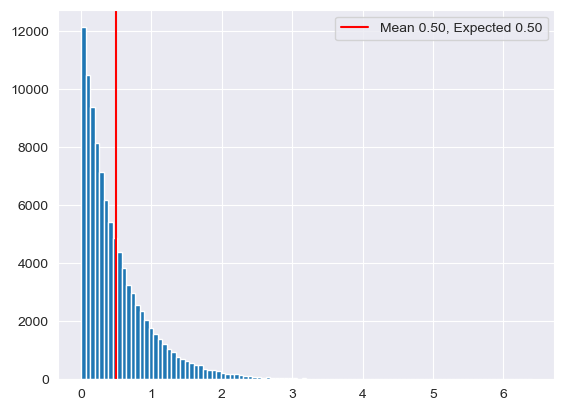

In [17]:
sampled = [np.random.exponential(MEAN_TIME_TO_NEXT_REQUEST) for _ in range(100000)]
plt.hist(sampled, bins=100)
plt.axvline(x=(mean:=np.mean(sampled)), color='r', label=f'Mean {mean:.2f}, Expected {MEAN_TIME_TO_NEXT_REQUEST:.2f}')
plt.legend()
plt.show()

## Distribution for time required to fulfill the request

To model what's the amount of time required to process a request, a right-skewed distribution seemed a reasonable choice. We want to emulate the fact that the majority of requests have similar completion time, but sometimes, some outliers requests appear, that require long time to complete. For this reason, a right-skewed with long-tailed distribution like a well set log-normal distribution seems reasonable. 

$$X \sim e ^ {Y}; Y \sim \mathcal{N}(\mu, \sigma ^ 2)$$ 

Where $X$ is our log-normal distribution, while $Y$ is a gaussian distribution.

On average, we want to have a request to have $\mathbb{E}[X] = 5$ = `MEAN_TIME_TO_FULFILL`. As we have 5 nodes per load balancer, we expect in an optimal scenario to have the overall time to completion reduced to a minimum.

In numpy's implementation, we set the $\mu$ and $\sigma$ of $Y$: therefore, to have $E[X] = 5$, we can compute which $\mu$ and $\sigma$ we need to obtain the desidered expected value.

$$E[X] = e ^ {\mu + \frac{\sigma ^ 2}{2}} $$

By manually identifying $\sigma = 0.5$ as a good candidate, we can trivially compute $\mu = ln(5) - \frac{0.5 ^ 2}{2}$

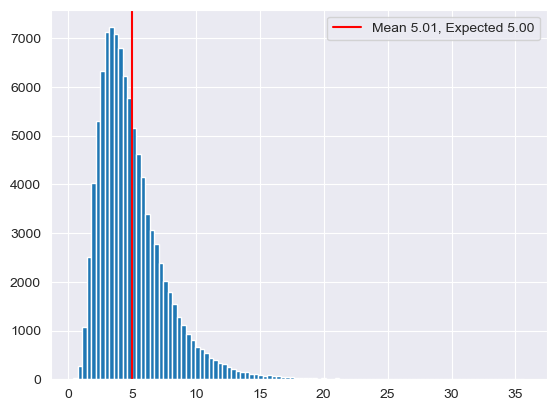

In [18]:
sampled = [np.random.lognormal(mean=np.log(MEAN_TIME_TO_FULFILL) - (0.25 / 2), sigma=0.5) for _ in range(100000)]
plt.hist(sampled, bins=100)
plt.axvline(x=(mean:=np.mean(sampled)), color='r', label=f'Mean {mean:.2f}, Expected {MEAN_TIME_TO_FULFILL:.2f}')
plt.legend()
plt.show()

# Visual representation of the various strategies

For each of the three strategies, let's show with an interaction and simulate requests coming through and being processed. Moreover, we'll keep track of the cumulative time necessary for the whole Node Balancer to fulfill all the requests, and plot this quantity through time.

## Round Robin

Text(0.5, 0, 'Time')

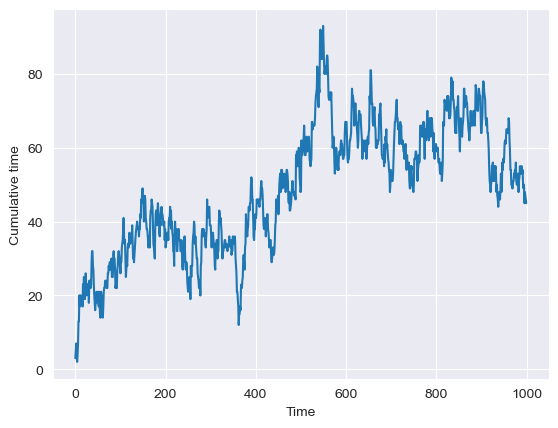

In [19]:
cumulative_time_remaining = simulate_with_visuals(
    load_balancer_strategy="round_robin",
    seed=1337,
)
plt.plot(np.arange(len(cumulative_time_remaining)), cumulative_time_remaining)
plt.ylabel("Cumulative time")
plt.xlabel("Time")

Text(0.5, 0, 'Time')

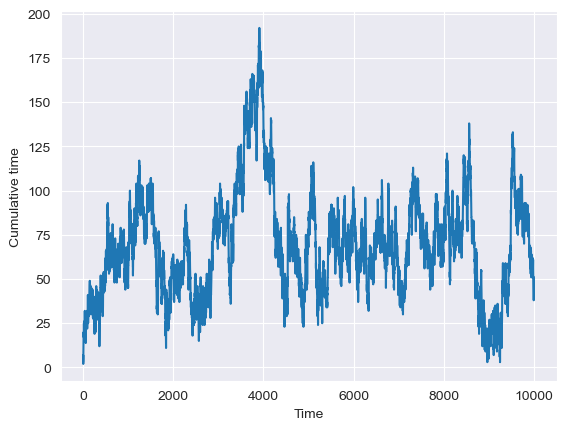

In [22]:
cumulative_time_remaining, _ = simulate(
    load_balancer_strategy="round_robin",
    total_time_simulation=10000,
    seed=1337,
)
plt.plot(np.arange(len(cumulative_time_remaining)), cumulative_time_remaining)
plt.ylabel("Cumulative time")
plt.xlabel("Time")

While fluctuating, a round-robin configuration seems to oscillate around 75 units of cumulative time remaining. 

## Hash

Text(0.5, 0, 'Time')

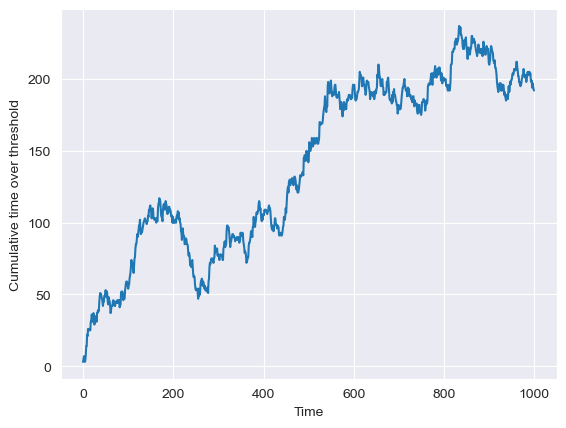

In [23]:
cumulative_time_remaining = simulate_with_visuals(
    load_balancer_strategy="hash_based",
    seed=1337,
)
plt.plot(np.arange(len(cumulative_time_remaining)), cumulative_time_remaining)
plt.ylabel("Cumulative time over threshold")
plt.xlabel("Time")

Text(0.5, 0, 'Time')

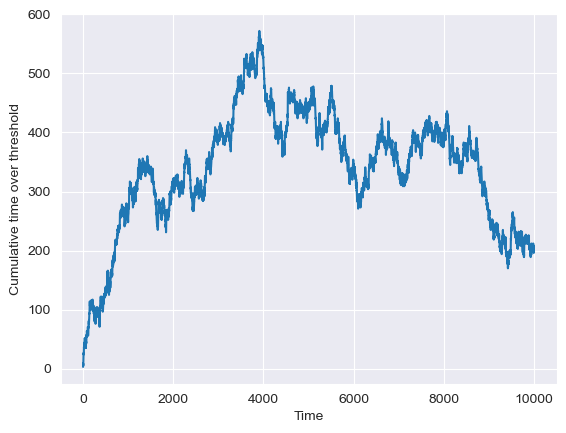

In [24]:
cumulative_time_remaining, _ = simulate(
    load_balancer_strategy="hash_based",
    total_time_simulation=10000,
    seed=1337,
)
plt.plot(np.arange(len(cumulative_time_remaining)), cumulative_time_remaining)
plt.ylabel("Cumulative time over threshold")
plt.xlabel("Time")

Even a quick glance shows how a random assignment can be much worse than round-robin!

## Least loaded

While this setting may not be feasible in every scenario, I wanted to test an ideal case, where we know exactly which node as the least amount of computation to perform, and re-direct a request there.

Text(0.5, 0, 'Time')

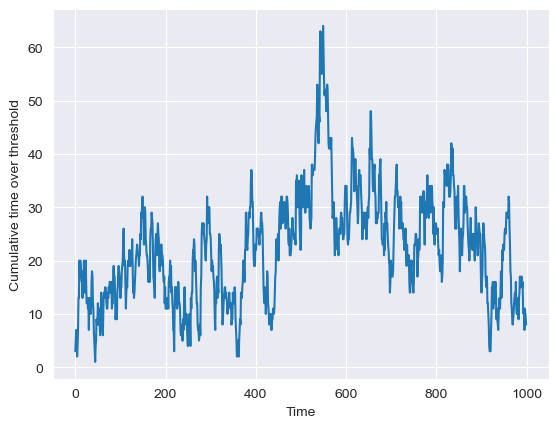

In [25]:
cumulative_time_remaining = simulate_with_visuals(
    load_balancer_strategy="least_loaded",
    seed=1337,
)
plt.plot(np.arange(len(cumulative_time_remaining)), cumulative_time_remaining)
plt.ylabel("Cumulative time over threshold")
plt.xlabel("Time")

Text(0.5, 0, 'Time')

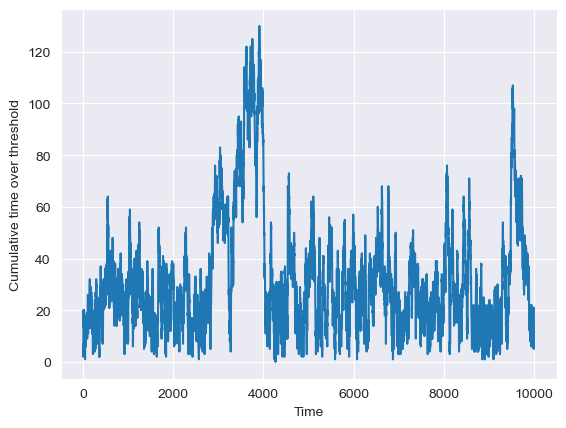

In [26]:
cumulative_time_remaining, _ = simulate(
    load_balancer_strategy="least_loaded",
    total_time_simulation=10000,
    seed=1337,
)
plt.plot(np.arange(len(cumulative_time_remaining)), cumulative_time_remaining)
plt.ylabel("Cumulative time over threshold")
plt.xlabel("Time")

As expected, the cumulative time it's much lower than both round-robin and random.

# Simulations

As of now, we have been running only one simulation per each strategy. Let's run multiple iterations and check their behavior. In the plots, the average value $\pm 2\sigma$ confidence is shown.

## Round Robin

<Axes: xlabel='time', ylabel='cumulative_time_to_fulfill_requests'>

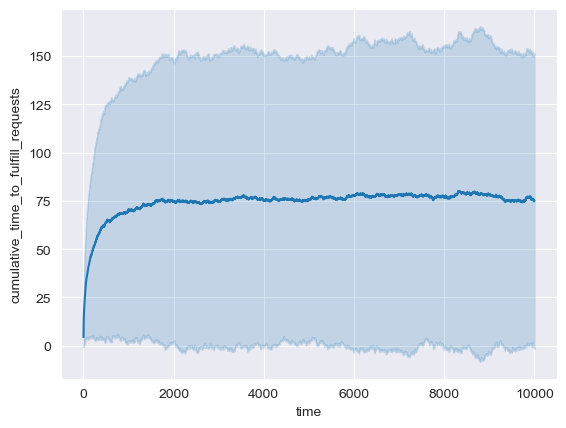

In [27]:
df_round_robin = simulate_n_times(
    n_simulations=1000,
    load_balancer_strategy="round_robin",
    total_time_simulation=10000,
    seed=1337,
)
sns.lineplot(
    data=df_round_robin.to_pandas(),
    x="time",
    y="cumulative_time_to_fulfill_requests",
    errorbar=("sd", 2),
)

In [30]:
df_round_robin.filter(pl.col('time') > 2000)['cumulative_time_to_fulfill_requests'].mean()

76.57196262032754

As noticed before, with our current settings round-robin seems to converge to an average cumulative time in the load balancer of ~75. 

## Hash

<Axes: xlabel='time', ylabel='cumulative_time_to_fulfill_requests'>

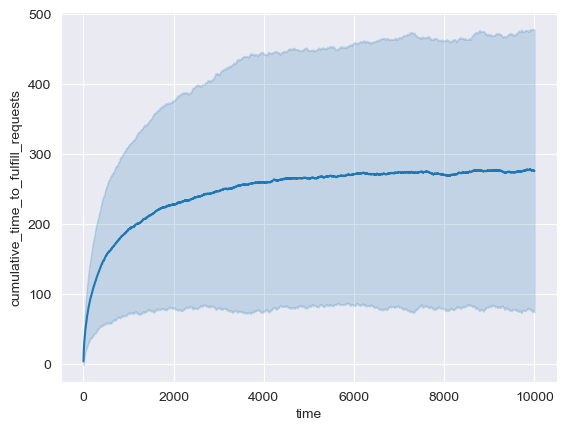

In [28]:
df_hash = simulate_n_times(
    n_simulations=1000,
    load_balancer_strategy="hash_based",
    total_time_simulation=10000,
    seed=1337,
)
sns.lineplot(
    data=df_hash.to_pandas(),
    x="time",
    y="cumulative_time_to_fulfill_requests",
    errorbar=("sd", 2),
)

In [29]:
df_hash.filter(pl.col('time') > 6000)['cumulative_time_to_fulfill_requests'].mean()

273.9706849212303

Random assignment is disastrous, being ~3.5 times worse than round-robin! 

## Least loaded

<Axes: xlabel='time', ylabel='cumulative_time_to_fulfill_requests'>

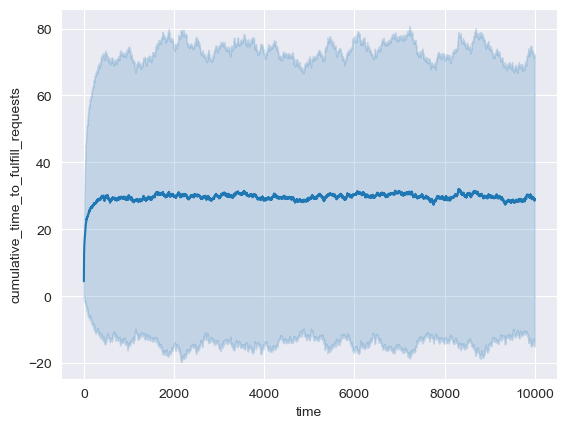

In [31]:
df_least_loaded = simulate_n_times(
    n_simulations=1000,
    load_balancer_strategy="least_loaded",
    total_time_simulation=10000,
    seed=1337,
)
sns.lineplot(
    data=df_least_loaded.to_pandas(),
    x="time",
    y="cumulative_time_to_fulfill_requests",
    errorbar=("sd", 2),
)

In [32]:
df_least_loaded.filter(pl.col('time') > 1000)['cumulative_time_to_fulfill_requests'].mean()

29.75997266362929

This last approach shows how much we can push the total cumulative time, obtaining a speed up against round-robin of ~2.5x times.

# Comparison

<Axes: xlabel='time', ylabel='cumulative_time_to_fulfill_requests'>

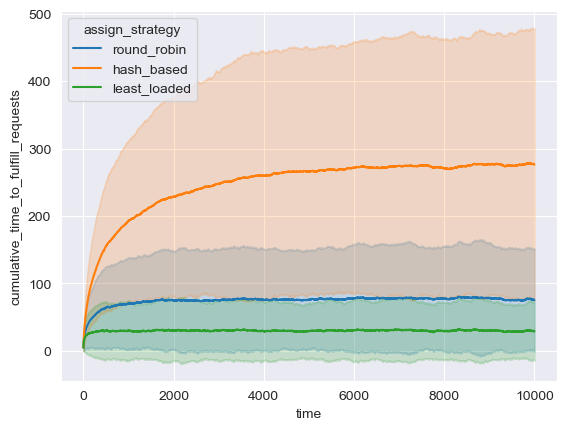

In [33]:
df_round_robin = df_round_robin.with_columns(assign_strategy=pl.lit("round_robin"))
df_hash = df_hash.with_columns(assign_strategy=pl.lit("hash_based"))
df_least_loaded = df_least_loaded.with_columns(assign_strategy=pl.lit("least_loaded"))

sns.lineplot(
    data=pl.concat([df_round_robin, df_hash, df_least_loaded]).to_pandas(),
    x="time",
    y="cumulative_time_to_fulfill_requests",
    hue="assign_strategy",
    errorbar=("sd", 2),
)

# Conclusions

Modelling the request coming in as an exponential with log-normal distribution for the time taken to complete the request, we noticed how:
- Round-robin performs much better than simply assigning at random; around 3.5x times better
- Being able to assess which node has the least amount of load in a given time can be key for obtaining the best performances. While in practice this may be difficult to achieve, we can use proxies metrics to achieve a similar goal, such as the size of the request in bytes or the CPU usage
- Finally, assigning at random leads to a whopping ~9x times higher cumulative time in the load balancer against assigning to the least loaded node. This shows how important is the algorithm selection of a node balancer, and how much impact it can have.